In [9]:
import os
import sys
from pathlib import Path
module_path = Path('.').absolute().parents[4]
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))
    
from datetime import datetime, date, time
from capstone.quant.backtest.strategies.futures_spread import FuturesSpread, FuturesSpreadState
from capstone.quant.backtest.backtester import LocalBacktester
from capstone.quant.infrastructure.future_data_container import DatalakeBBGFuturesDataSource, FutureDataRequest
from capstone.quant.infrastructure.fx_data_container import DatalakeBBGFXDataSource, FXDataRequest
from capstone.quant.tradable.portfolio import Portfolio
from capstone.quant.tradable.constant import Constant
from capstone.quant.dates.utils import minus_tenor
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [14]:
start_date = datetime(2009, 9, 14)
end_date = datetime(2024, 7, 31)

long_root = 'IK'
short_root = 'RX'
suffix = 'Comdty'
extra_holidays = [datetime(2017, 1, 2), datetime(2023, 1, 2)]
calendar = ['XFRA'] + extra_holidays
currency = 'USD'

# define instance of a strategy
futures_spread_strategy = FuturesSpread(
    start_date=start_date,
    end_date=end_date,
    calendar=calendar,
    currency=currency,
    parameters={
        'long': {
            'underlying': long_root,
            'target_notional': 100,
        },
        'short': {
            'underlying': short_root,
            'target_notional': -100,
        },
        'roll_offset': 3,
        'tc_rate': 0.0005,
    },
    data_requests={
        'long': (
            FutureDataRequest(start_date, end_date, calendar, long_root, suffix, 2),
            DatalakeBBGFuturesDataSource()
        ),
        'short': (
            FutureDataRequest(start_date, end_date, calendar, short_root, suffix, 2),
            DatalakeBBGFuturesDataSource()
        ),
        'fx': (
            FXDataRequest(start_date, end_date, calendar, currency='EUR', denominator_currency=currency, fixing_type='L160'),
            DatalakeBBGFXDataSource()
        )
    }

)

In [15]:
# run backtest
runner = LocalBacktester()
results = runner.run(futures_spread_strategy, start_date, end_date, FuturesSpreadState(start_date, Portfolio([]), 0.0, 0.0))

records = [{'date': x.time_stamp, 'pnl': x.price} for x in results]
pnl_series = pd.DataFrame.from_dict(records)

5435it [00:02, 2486.69it/s]


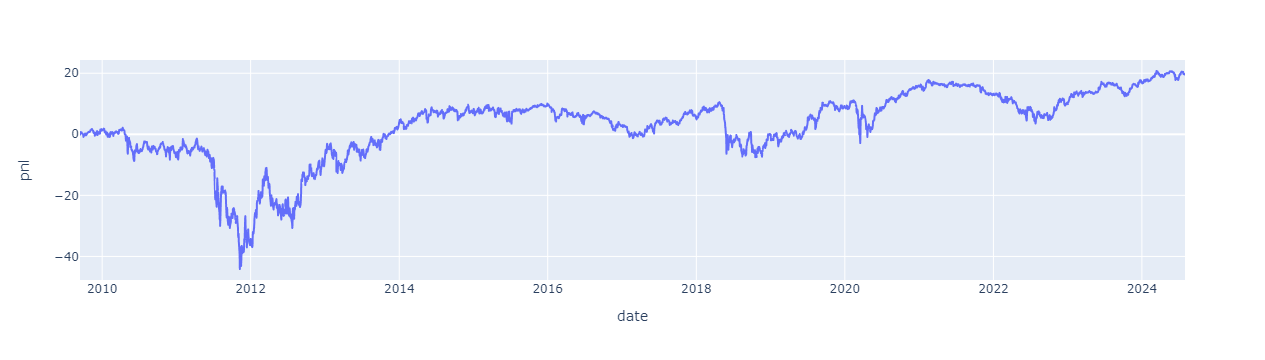

In [16]:
fig = px.line(
    pnl_series,
    x='date',
    y='pnl',
    labels={'value': 'PnL'},
)
fig.show()

In [17]:
portfolio_expanded = []
for state in results:
    for k, v in state.portfolio.net_positions().items():
        if not isinstance(v.tradable, Constant):
            portfolio_expanded.append({
                'date': state.time_stamp,
                'position': k,
                'quantity': v.quantity,
                'price': v.price
            })
portfolio_expanded = pd.DataFrame.from_records(portfolio_expanded)

In [18]:
portfolio_expanded.tail()

,date,position,quantity,price
11329,2024-07-30,RXU24 Comdty,-0.757805,144.11709
11330,2024-07-30,EURCash,-12.237658,1.08050
11331,2024-07-31,IKU24 Comdty,0.846597,128.71472
11332,2024-07-31,RXU24 Comdty,-0.757805,144.69586
11333,2024-07-31,EURCash,-12.237658,1.08200
